<a href="https://colab.research.google.com/github/hongsy0113/cose461-NLP-project-choi-hong/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install soynlp
!pip install konlpy

from soynlp.normalizer import *
import soynlp

import json
from pandas import json_normalize

import torch
from torch import nn

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# json data 파일들을 google drive에 저장
# google drive 에 있는 파일들을 접근하기 위해 mount
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#위에서의 json2df 함수 수정함
def json2df (file):
  with open(file, 'r') as f:
    jdata = json.load(f)
  
  meta_list = [['header', 'dialogueInfo', 'numberOfParticipants'],
             ['header', 'dialogueInfo', 'numberOfUtterances'],
             ['header', 'dialogueInfo', 'dialogueID'],
            ]
  # dataframe of utterances 
  df1 = pd.json_normalize(jdata['data'][:], record_path=['body'], meta= meta_list, errors='ignore')
  # dataframe of participants info
  df2 = pd.json_normalize(jdata['data'], record_path=['header', 'participantsInfo'],  meta= [['header', 'dialogueInfo', 'dialogueID']], errors='ignore')
  # join df1 and df2 where (df1.dialogueID == df2.dialogueID and df1.participantID == df2.participantID)
  df = pd.merge(left = df1 , right = df2, how = "left", on = ["header.dialogueInfo.dialogueID", 'participantID' ],sort=False)

  # rename column names
  # 열이름 너무 길어서 바꿈. P는 참가자, U는 메시지, D는 대화, T는 turn 으로 통일시킴. 맘에 안 들면 바꿔도 ok
  df.rename(columns = {'header.dialogueInfo.numberOfParticipants' : 'P_num', 
                       'header.dialogueInfo.numberOfUtterances': 'U_num', 
                       'header.dialogueInfo.dialogueID':'D_id',
                       'utteranceID':'U_id',
                       'participantID':'P_id',
                       'gender':'P_gender',
                       'age':'P_age'}, inplace = True)

  df= df[['utterance', 'U_id', 'P_id', 'P_num', 'D_id', 'P_gender']]

  # 대화 id 를 0부터 일련번호로 변경
  D_id_list = []

  num = -1 
  current = None
  for id in df['D_id']:
    if id != current:
      num +=1
      current = id
    D_id_list.append(num)

  df['D_id'] = D_id_list

  return df


# 행사.json, 식음료.json 등 여러 데이터셋을 하나로 만들기 위한 함수
def concat_json2df (file_list):
  result = None

  for i, file in enumerate(file_list):
    df = json2df(file)
    if (i==0):
      result = df.copy()
    else:
      result = pd.concat([result,df])
  return result

In [4]:
f_list = ['/content/gdrive/MyDrive/cose461/일과직업.json',
          '/content/gdrive/MyDrive/cose461/시사교육.json',
          '/content/gdrive/MyDrive/cose461/행사.json',
          '/content/gdrive/MyDrive/cose461/개인및관계.json',
          '/content/gdrive/MyDrive/cose461/미용과건강.json']

raw_df = concat_json2df(f_list)


raw_df.head(20)

KeyboardInterrupt: ignored

In [ ]:
df = raw_df.copy()

# 1. lstm 모델

https://wikidocs.net/44249 
이 내용 거의 따라함

 lstm 모델 따라하기 2 의 아이디어
- 같은 화자의 데이터는 하나의 덩어리로 처리하도록

In [ ]:
# Naive-Bayes Method.
#df = df[['utterance', 'P_gender']]
df['P_gender'].value_counts()

여성    970761
남성    195332
Name: P_gender, dtype: int64

In [ ]:
# Gender to discrete variable
# 0 : '여성', 1 : '남성'
df['P_gender'] = [0 if gender=='여성' else 1 for gender in df['P_gender']]
df = df.set_index(['D_id','P_id'] )

In [ ]:
df = df.sort_index()
df['index'] = df.index
df.head(5)

utterance U_id P_num  P_gender     index
D_id P_id                                                  
0    P01       여러 명 같이 하나보네?   U1     2         0  (0, P01)
     P01             #@이모티콘#   U2     2         0  (0, P01)
     P01                   아   U5     2         0  (0, P01)
     P01           강제로 쉬는 시간   U6     2         0  (0, P01)
     P01   평일엥 일하겠네 우리 #@이름#   U7     2         0  (0, P01)

In [ ]:
s = df.groupby(df.index)['utterance'].apply(' '.join).to_frame()

s.head(15)

,utterance
"(0, P01)",여러 명 같이 하나보네? #@이모티콘# 아 강제로 쉬는 시간 평일엥 일하겠네 우리 ...
"(0, P02)",응 한 10명? 프로그램 다운이 안 됐대 다음 주부터는 바쁘겠다
"(1, P01)",그래도 스케줄은 그지같이 안짤거 아니야 #@이모티콘# ㅋㅋㅋㅋ 이제 쓸 연차도 없지...
"(1, P02)",전 정말 웃음이 안나요 그게 다행이져 ㅋㅋㅋㅋㅋㅋㅋ 내 연차 함부로 안써줬으면 좋겠...
"(2, P01)",근데 만약에 남성이 결혼을 안한다면 기혼자와 미혼자 간의 휴가 차이가 발생하지 않을...
"(2, P02)",응 그렇겠지 미혼자들이 아무래도 불공평하다고 느낄거야 아니면 미혼자만을 위한 휴가를...
"(3, P01)",헐쌤 그럼 내가 전화해본거 아실꺼 아니야ㅠㅠ 나 이상하게 보겠어ㅠㅠ ㅠㅠ나 안 그래...
"(3, P02)",아니 그건 아님 #@이름#이 전화한거 아셔 긍까 낼 어린이집 방학 얘기 하지마 낼 ...
"(4, P01)","추석 앞앞 날부터 3일쉬고! ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 대신 오늘 쉽니다,, 어냐아녀 ..."
"(4, P02)",아이고야.... 추석때도 그럼 일했겠네.. 아 연달아 쉰다는 소리로 착각함..


In [ ]:
df = pd.merge(left = s.reset_index(), right = df[['P_gender','index']], how = "left", left_on=['index'], right_on= ['index'], sort=False).drop_duplicates().set_index('index').reset_index()
df

,index,utterance,P_gender
0,"(0, P01)",여러 명 같이 하나보네? #@이모티콘# 아 강제로 쉬는 시간 평일엥 일하겠네 우리 ...,0
1,"(0, P02)",응 한 10명? 프로그램 다운이 안 됐대 다음 주부터는 바쁘겠다,0
2,"(1, P01)",그래도 스케줄은 그지같이 안짤거 아니야 #@이모티콘# ㅋㅋㅋㅋ 이제 쓸 연차도 없지...,0
3,"(1, P02)",전 정말 웃음이 안나요 그게 다행이져 ㅋㅋㅋㅋㅋㅋㅋ 내 연차 함부로 안써줬으면 좋겠...,0
4,"(2, P01)",근데 만약에 남성이 결혼을 안한다면 기혼자와 미혼자 간의 휴가 차이가 발생하지 않을...,1
...,...,...,...
164409,"(76197, P04)",펜트하우스 보는데 홀린듯 계속보게되네 지금 보고잇는데 엄마 옆에서 계속 스포하는 중이다ㅠ,0
164410,"(76198, P01)",ㅋㅋㅋㅋㅋㅋ 사이버 대학이라 바뀌는게 없다 ㅋㅋㅋ 딴데도 찾아봐 헐랭 여자라 그런가...,1
164411,"(76198, P02)",ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 난 내일도 쿠팡 되길... 마켓컬리 두번 지원했는데 두번다 ...,0
164412,"(76199, P01)",남자부사수 생기는데~ 이게 하렘아니고 뭐노 너 빠른이니까 무시하지말라해 정정합니다 ...,0


In [64]:
df = pd.read_csv('/content/gdrive/MyDrive/cose461/data_50.csv')
df

,index,utterance,P_gender
0,"('005b53d1-8c3f-55a7-8fa1-537b6a55a2ee', 'P02')",음 근데 경기도가 차없으면 여기저기 둘러보기 너무 광범위해서 일산 말고는 나도 경기...,0
1,"('f3503e1d-2070-5b4b-a7ba-695b67541f6a', 'P01')",어디로 데리러가면 좋을까? 가는길을 몰라성ㅋㅋ 여툰 아래로 내려가잖아?? 물어보고 ...,0
2,"('b215588e-5d90-5d5f-bca2-4d284602584a', 'P02')",ㅋㅋㅋㅋㅋㅋㅋ아왜 금욜 운동가자~ ㅇ키오키오키 좋아 ㅜㅜ 나도 갈까 목욕탕~!,0
3,"('7772face-28c9-5f4a-9b10-2c6b523c3322', 'P01')",독립밀방 여기도 유명한가보네 ㅋㅋ 안에 잘 해놨네... 월요일에 가서 점심 먹고 카...,0
4,"('32458022-1f17-5198-8225-48f81f050024', 'P01')","음 방콕간거 거짓말이지 #@이름#언니 행복해보이네,,,,, ㅋㅋㅋㅋㅋㅋㅋㅋ#@이름#...",0
...,...,...,...
498507,"('921de53b-a103-5887-af79-31bde666efaa', 'P01')",사회복지사 꽤 많이 범 공무원처럼 호봉제라 내 후배처럼 군대 안다녀오고 25-6살부...,1
498508,"('080de6ed-cf83-5136-9f11-d77040a6b132', 'P01')",이랬음ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ ㅋㅋㅋㅋㅋㅋㅋㅋ...,1
498509,"('fd0deffe-8c62-54ba-a3e7-98e147bd5d6a', 'P02')",ㅋㅋㅋㅋㅋ 그게낫지 er69연맹 각 얼른문의해봐라 ㅋㅋㅋ답오냐 오는거보고 고민해보마ㅋㅋㅋ,1
498510,"('d05a2f1e-9453-5771-a124-fc5926dd0308', 'P02')",응 추석끝나고 말해 추석이라 다들 돈좀 나갈꺼 응 그렇게해,1


In [7]:
from soynlp.tokenizer import RegexTokenizer
from soynlp.normalizer import *

tokenizer = RegexTokenizer()

# soynlp 설명 참고 링크
#https://github.com/lovit/soynlp
# df['utterance'] 에서 ㅋㅋㅋㅋㅋ와 같이 반복되는 글지 normalize 하고 tokenize

def text_normalize(sent):
  #result= emoticon_normalize(sent, num_repeats= 2)
  result = tokenizer.tokenize(sent)
  for i, token in enumerate(result):  
    tmp = emoticon_normalize(token, num_repeats= 2)
    result[i] = repeat_normalize(tmp, num_repeats=1)
    #result[i] = tmp
    pass
  return result

df['sents'] = df['utterance'].apply(text_normalize)
df.head(10)

,index,utterance,P_gender,sents
0,"('d681fd70-af0d-5821-bd54-f411a26a2551', 'P01')",나 할미 생일이라서 파뤼파뤼~ 저녁 먹고 올게 먹구옴 나원래 혼자 먹고 방에 들어옴...,0,"[나, 할미, 생일이라서, 파뤼파뤼, ~, 저녁, 먹고, 올게, 먹구옴, 나원래, ..."
1,"('a9458b1e-2eb0-51b3-869e-665816baa439', 'P02')",근데 서울은 요즘 초큼 그런거같기두하공 ㅠ 부평? 삼산동? 오 상동어디??,0,"[근데, 서울은, 요즘, 초큼, 그런거같기두하공, ㅠ, 부평, ?, 삼산동, ?, ..."
2,"('349322b2-f378-536e-a458-334b467bbb53', 'P02')",그니까 ㅋㅋㅋㅋㅋㅋ 맘먹었어지금ㅋㅋㅋㅋㅋㅋ 담에 집들이때나 해서 같이 한번 모여보장 오올,0,"[그니까, ㅋㅋ, 맘먹었어지금, ㅋㅋ, 담에, 집들이때나, 해서, 같이, 한번, 모..."
3,"('6721f5f0-5b9e-5e76-b5a8-dca6271695b0', 'P04')",내는 지하철,0,"[내는, 지하철]"
4,"('b1300897-af6a-5a39-aa15-e7901c7137c9', 'P03')",강화도?,0,"[강화도, ?]"
5,"('d869613c-5add-5b2b-8df4-7c33233ed6ee', 'P01')",여행하면서 많이 만나네 어떤 사람은 라오스에서 남친 만났대 라오스 남부를 갔대.. ...,0,"[여행하면서, 많이, 만나네, 어떤, 사람은, 라오스에서, 남친, 만났대, 라오스,..."
6,"('7ad5adee-b626-5d94-8a47-11e18b9fdb4d', 'P02')",둘다 똑같은데 공항은 혹시 늦거나 기다려야되거나 시간 촉박할까바 그러는거가툼 둘다똑...,0,"[둘다, 똑같은데, 공항은, 혹시, 늦거나, 기다려야되거나, 시간, 촉박할까바, 그..."
7,"('00b2ad12-cf69-5755-bdca-0f453b4f175d', 'P01')",어이없어 아니야~그냥 돌아가는것도 싫고 해서 탔어 도착지도 그냥 그 105번 내리는...,0,"[어이없어, 아니야, ~, 그냥, 돌아가는것도, 싫고, 해서, 탔어, 도착지도, 그..."
8,"('74034247-a526-50d4-8494-c01e557c72cc', 'P02')",저녁에 갈거야 너는? 집에 간다고 너는? 7시 응 어디 아프니? 잘했쓰~~~ 그래라,0,"[저녁에, 갈거야, 너는, ?, 집에, 간다고, 너는, ?, 7, 시, 응, 어디,..."
9,"('32da1e90-947b-5729-89ae-62d8294077e0', 'P02')",님잠만여 저 밖이엿어요 깨잇어?? 요즘 같습니다 ㅋㅋㅋㅋㅇ 일할때보다 뭔가 더 나돌...,0,"[님잠만여, 저, 밖이엿어요, 깨잇어, ??, 요즘, 같습니다, ㅋㅋㅇ, 일할때보다..."


In [65]:
from soynlp.normalizer import *
from konlpy.tag import Okt
import re

okt = Okt()

def clean(doc) :

  new_doc = list()
  doc = okt.pos(doc, norm=True)

  stop_tags = ['Determiner', 'Josa', 'Foreign']
  stop_words = ['은', '는', '이', '가', '', '이름']
  for text, tag in doc:  

    if tag in stop_tags:
      continue

    text = re.sub(r'[^ㄱ-ㅣ가-힣?.!~\^]+', '', text)  # remove digits.  
    text = emoticon_normalize(text, num_repeats=2) # remove repeated emoticon. e.g) ㅋㅋㅋㅋ=>ㅋㅋ, ㅠㅠㅠㅠ=>ㅠㅠ
    text = repeat_normalize(text, num_repeats=1) # remove repeated character
    
    if text in stop_words or (tag=='Verb' and len(text)<=1):
      continue
      
    new_doc.append(text)

  return new_doc

In [66]:
df['sents'] = df['utterance'].apply(clean)
df.head(10)

,index,utterance,P_gender,sents
0,"('005b53d1-8c3f-55a7-8fa1-537b6a55a2ee', 'P02')",음 근데 경기도가 차없으면 여기저기 둘러보기 너무 광범위해서 일산 말고는 나도 경기...,0,"[음, 근데, 경기도, 차, 없으면, 여기저기, 둘러보기, 너무, 광범위해서, 일산..."
1,"('f3503e1d-2070-5b4b-a7ba-695b67541f6a', 'P01')",어디로 데리러가면 좋을까? 가는길을 몰라성ㅋㅋ 여툰 아래로 내려가잖아?? 물어보고 ...,0,"[어디, 데리러, 가면, 좋을까, ?, 가는, 길, 몰라, 성, ㅋㅋ, 여툰, 아래..."
2,"('b215588e-5d90-5d5f-bca2-4d284602584a', 'P02')",ㅋㅋㅋㅋㅋㅋㅋ아왜 금욜 운동가자~ ㅇ키오키오키 좋아 ㅜㅜ 나도 갈까 목욕탕~!,0,"[ㅋㅋㅋ, 아, 왜, 금욜, 운동, 가자, ~, ㅇ, 키, 오키, 오키, 좋아, ㅜ..."
3,"('7772face-28c9-5f4a-9b10-2c6b523c3322', 'P01')",독립밀방 여기도 유명한가보네 ㅋㅋ 안에 잘 해놨네... 월요일에 가서 점심 먹고 카...,0,"[독립, 밀방, 여기, 유명한, 가보네, ㅋㅋ, 안, 해놨네, ..., 월요일, 가..."
4,"('32458022-1f17-5198-8225-48f81f050024', 'P01')","음 방콕간거 거짓말이지 #@이름#언니 행복해보이네,,,,, ㅋㅋㅋㅋㅋㅋㅋㅋ#@이름#...",0,"[음, 방콕, 간거, 거짓말, 언니, 행복, 해보이네, ㅋㅋㅋ, 니, 여행, 중, ..."
5,"('46ca6704-6cfd-53b5-af94-beb01e806699', 'P02')",나도 모르겠어 일단 올해는 열심히 돈벌고 여행가기로 충분해 맞아 사실 그걸 바래..,0,"[나도, 모르겠어, 일단, 올해, 열심히, 돈, 벌고, 여행, 가기, 충분해, 맞아..."
6,"('e141faf2-59c9-52da-98eb-953d9dcd9cea', 'P03')",어디가요엄마아빠?!🍘🍦🍣🍬❤❤ 너무귀엽다💘💘,0,"[어디가, 엄마, 아빠, ?!, 너무, 귀엽다]"
7,"('2d258296-134b-5e75-a38d-184de67017a3', 'P01')",#@이름# 이사 언제함? 집은 구함? 글쿤ㅋㅋ 어디로 가게? 이사가면 집들이 해ㅋㄱ...,0,"[이사, 언, 제, 함, ?, 집은, 구함, ?, 글쿤, ㅋㅋ, 어디, 가게, ?,..."
8,"('9df529fd-25ca-5dde-89af-d116f4102871', 'P02')",아예 온거야??? 오 그러면 우리 함 봐야하는거 아니냥~~~~ 언제 가?? 그럼 가...,0,"[아예, 온거야, ???, 오, 그러면, 우리, 함, 야하는거, 아니냥, ~~~~,..."
9,"('59a0583a-0e0d-52ab-8d73-24e442db3b14', 'P02')",와 혼자 꿀잠자는거에바지 나는 11시에인났는데ㅜ 그러고 원주가는중 갑분원주 ㅋㅋㅋㅋ...,0,"[혼자, 꿀잠, 자는거에, 바지, 나, 시, ㅜ, 그러고, 원, 주가, 중, 갑, ..."


데이터 전처리 고려해야 할 점 ㅜㅜ

- ㅋㅋㅋㅋ, ㅇㅇㅇㅇ 어떻게 처리할지. 단순히 여러개 있어도 다 같은 걸로 취급할지 말지
- !, ? 도 마찬가지. soynlp의 textonly 함수를 통해 기호들은 제거가 쉽게 가능할듯 한데. 그럼 정보의 손실이 있을수도
- 이모티콘 이름. 우리 데이터에서 사람 이름은 #@이름# 으로 되어있음. 
- 형태소 분석

In [8]:
df_women = df[df['P_gender']==0]
df_men = df[df['P_gender']==1]

print("Number of women : {}, Number of men : {}".format(df_women['P_gender'].value_counts()[0], df_men['P_gender'].value_counts()[1]))

NameError: ignored

In [ ]:
df_women = df_women.sample(n= df_men['P_gender'].value_counts()[1], random_state=7)
df = pd.concat([df_women, df_men], sort=True)
df.head()

,P_gender,index,sents,utterance
22753,0,"('e27eca6c-9402-5998-969f-26a62d2dbeb9', 'P02')","[아, 진짜, ??, 나, 즙, 엄청, 잘, 먹잖아, ㅋㅋ, 건강, 챙긴다구, 웅웅...",아 진짜?? 나 즙 엄청 잘 먹잖아 ㅋㅋ 건강 챙긴다구 웅웅 그래도 좀 조심히 먹긴...
38726,0,"('209957eb-90f1-53ba-9126-643ef9766c9b', 'P02')","[그럼, 천부터, 먹지말라하던가, 원래, 앞에서, 뭐라안함, 아니, 난, 또, 짜중...",그럼 천부터 먹지말라하던가 원래 앞에서 뭐라안함 아니 난 또 짜중나는게 혼날때 혼내...
96021,0,"('4f0a3407-1143-55c0-913a-781bb0ea17db', 'P02')","[그래도, 너무, 낮추진, 말고, 인간답게, 일할, 수, 있는, 곳으로, 언니가, ...",그래도 너무 낮추진 말고 인간답게 일할 수 있는 곳으로 언니가 어느정도 커트라인 만...
15966,0,"('bd6ffa82-aaee-5f59-98b1-c86d500b4d71', 'P02')","[맞아, ..., 책, 읽는게, 진짜, ..., 맞춤법에도, 그렇고, 어휘력에도, ...",맞아... 책 읽는게 진짜... 맞춤법에도 그렇고 어휘력에도 그렇고 도움되는데 잘 ...
78,0,"('e707f585-d297-5ecc-9656-db07bd5aa745', 'P01')","[어, 7, 시다, 우리도, 준비하자, 이래요, 내가, 인사하면, ㅋㅋ, 벌써, 7...",어 7시다 우리도 준비하자 이래요 내가 인사하면 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...


In [67]:
X = df['sents']
y = df['P_gender']

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)



In [68]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [69]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)     # data 적게 할 때는 division by zero 나올수도
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 394402
등장 빈도가 2번 이하인 희귀 단어의 수: 282664
단어 집합에서 희귀 단어의 비율: 71.66900776365232
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3794569190685797


In [70]:
# 전체 단어 개수 중 빈도수 threshold 이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 111739


In [71]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [72]:
y_train = np.array(y_train)
y_test = np.array(y_test)

메시지의 최대 길이 : 1096
메시지의 평균 길이 : 23.73793971550291


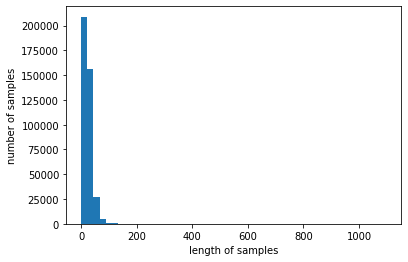

In [73]:
print('메시지의 최대 길이 :',max(len(l) for l in X_train))
print('메시지의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [74]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(50,X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 95.08561742588557


In [75]:
max_len = 50
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [76]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [77]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
# model.add(Dropout(0.3))
# model.add(LSTM(hidden_units, return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# model.summary()

In [78]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
4984/4986 [============================>.] - ETA: 0s - loss: 0.5942 - acc: 0.6765
Epoch 00001: val_acc improved from -inf to 0.68852, saving model to best_model.h5
4986/4986 [==============================] - 105s 21ms/step - loss: 0.5942 - acc: 0.6765 - val_loss: 0.5783 - val_acc: 0.6885
Epoch 2/15
4985/4986 [============================>.] - ETA: 0s - loss: 0.5396 - acc: 0.7248
Epoch 00002: val_acc improved from 0.68852 to 0.69611, saving model to best_model.h5
4986/4986 [==============================] - 105s 21ms/step - loss: 0.5396 - acc: 0.7248 - val_loss: 0.5715 - val_acc: 0.6961
Epoch 3/15
4984/4986 [============================>.] - ETA: 0s - loss: 0.4845 - acc: 0.7657
Epoch 00003: val_acc did not improve from 0.69611
4986/4986 [==============================] - 108s 22ms/step - loss: 0.4845 - acc: 0.7657 - val_loss: 0.5842 - val_acc: 0.6955
Epoch 4/15
4986/4986 [==============================] - ETA: 0s - loss: 0.4363 - acc: 0.7960
Epoch 00004: val_acc did not impr

In [79]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
# data_20 - 0.6718
# data_50 - 0.6970

3116/3116 [==============================] - 23s 7ms/step - loss: 0.5699 - acc: 0.6970

 테스트 정확도: 0.6970


In [ ]:
# 데이터 전처리 x
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
536/536 [==============================] - ETA: 0s - loss: 0.6279 - acc: 0.6456
Epoch 00001: val_acc improved from -inf to 0.67297, saving model to best_model.h5
536/536 [==============================] - 88s 159ms/step - loss: 0.6279 - acc: 0.6456 - val_loss: 0.6092 - val_acc: 0.6730
Epoch 2/15
536/536 [==============================] - ETA: 0s - loss: 0.5268 - acc: 0.7364
Epoch 00002: val_acc improved from 0.67297 to 0.67379, saving model to best_model.h5
536/536 [==============================] - 75s 140ms/step - loss: 0.5268 - acc: 0.7364 - val_loss: 0.6804 - val_acc: 0.6738
Epoch 3/15
536/536 [==============================] - ETA: 0s - loss: 0.4677 - acc: 0.7744
Epoch 00003: val_acc improved from 0.67379 to 0.67729, saving model to best_model.h5
536/536 [==============================] - 74s 139ms/step - loss: 0.4677 - acc: 0.7744 - val_loss: 0.6265 - val_acc: 0.6773
Epoch 4/15
536/536 [==============================] - ETA: 0s - loss: 0.4222 - acc: 0.8012
Epoch 00004:

In [ ]:
# 데이터 전처리 x
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

335/335 [==============================] - 7s 20ms/step - loss: 0.6215 - acc: 0.6663

 테스트 정확도: 0.6663
